## 导包

In [1]:
import numpy as np
import pandas as pd

# 建模工具
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 绘图参数调优
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## 导入数据

In [3]:
hour_df = pd.read_csv("../data/美国华盛顿地区共享单车使用量数据集.csv")
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


## 预处理

In [6]:
# 将列名重命名为更易读的名称
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'yr':'year'},inplace=True)

###########################
# 设置正确的数据类型
###########################
# 日期时间转换
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# 类别变量
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')

## 特征引擎

In [7]:
# 定义类别变量编码器方法
def fit_transform_ohe(df,col_name):
    """此函数为指定的对象执行一个热编码。
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # 标签对列进行编码
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # 单热点编码
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# 给定标签编码器和一个热点编码器对象，
# 将属性编码为ohe
def transform_ohe(df,le,ohe,col_name):
    """此函数为指定的对象执行一个热编码，使用指定的编码器对象的列。

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # 标签编码
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [8]:
# 将数据集分为培训和测试集
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3],
                                        hour_df.iloc[:,-1],
                                        test_size=0.33,
                                        random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [10]:
# 对所有类别功能进行编码
cat_attr_list = ['season','is_holiday','weather_condition','is_workingday','weekday','month','year']
# 小时、工作日等属性不需要此类编码。请进行此类编码。
numeric_feature_cols = ['temp','humidity','windspeed','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

###############
# 训练集
###############
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


feature_df_list  = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

##############
# 测试集
##############
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

Train dataset shape::(489, 17)
       temp  humidity  windspeed weekday month year  season_1  season_2  \
0  0.365833  0.581667   0.157346       4    11    1       0.0       0.0   
1  0.352174  0.333478   0.347835       4    11    1       0.0       0.0   
2  0.720833  0.545417   0.136212       1     8    1       0.0       0.0   
3  0.815833  0.518750   0.168529       0     7    1       0.0       0.0   
4  0.290833  0.395833   0.421642       6     2    1       1.0       0.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       0.0       1.0           1.0           0.0                  0.0   
1       0.0       1.0           1.0           0.0                  1.0   
2       1.0       0.0           1.0           0.0                  1.0   
3       1.0       0.0           1.0           0.0                  1.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  is_workingday_0  is_workingd

## 建模

In [11]:
# 构建训练数据集
X = train_df_new
y= y.total_count.values.reshape(-1,1)

# 构建测试数据集
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
print(X.shape,y.shape)

(489, 17) (489, 1)


In [12]:
dtm = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(X,y)
print("R-Squared on train dataset={}".format(dtm.score(X_test,y_test)))

dtm.fit(X_test,y_test)   
print("R-Squaredon test dataset={}".format(dtm.score(X_test,y_test)))

R-Squared on train dataset=0.7748465122427447
R-Squaredon test dataset=0.8523823887746997


## 使用GridSearchCV进行超参数调优

In [13]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X,y)

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [14]:
print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

R-Squared::0.7373219688043731
Best Hyperparameters::
{'criterion': 'mae', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [15]:
df = pd.DataFrame(data=grid_cv_dtm.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008323,0.004332,0.005116,0.001201,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.636771,0.58473,0.663558,0.624197,0.60402,0.622655,0.027056,73
1,0.014885,0.015431,0.026525,0.037410,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.636771,0.58473,0.663558,0.624197,0.60402,0.622655,0.027056,73
2,0.008539,0.004069,0.005923,0.004658,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.636771,0.58473,0.663558,0.624197,0.60402,0.622655,0.027056,73
3,0.006865,0.001700,0.003630,0.000470,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.636771,0.58473,0.663558,0.624197,0.60402,0.622655,0.027056,73
4,0.004130,0.000634,0.003893,0.000378,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",0.636771,0.58473,0.663558,0.624197,0.60402,0.622655,0.027056,73


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

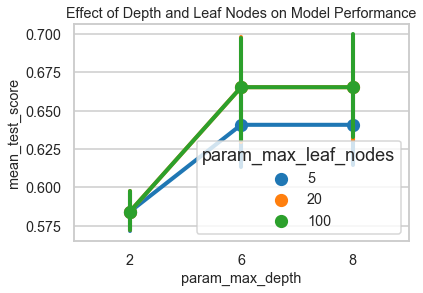

In [16]:
fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

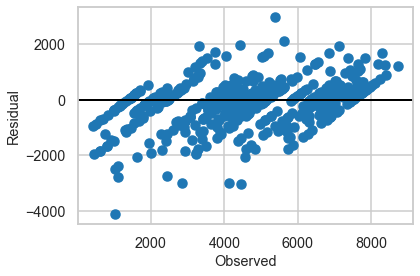

In [17]:
# 评估训练模型
predicted = grid_cv_dtm.best_estimator_.predict(X)
residuals = y.flatten()-predicted

fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [18]:
# 检查训练模型得分
r2_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

print("avg R-squared::{:.3f}".format(np.mean(r2_scores)))
print("MSE::{:.3f}".format(np.mean(mse_scores)))

/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

avg R-squared::0.725
MSE::-933829.419


/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/Users/soutsukyou/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 

## 测试数据集评估

In [19]:
best_dtm_model = grid_cv_dtm.best_estimator_

y_pred = best_dtm_model.predict(X_test)
residuals = y_test.flatten() - y_pred


r2_score = best_dtm_model.score(X_test,y_test)
print("R-squared:{:.3f}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-squared:0.744
MSE: 995394.45
